Class Activation Mapping In PyTorch


Have you ever wondered just how a neural network model like ResNet decides on its decision to determine that an image is a cat or a flower in the field? Class Activation Mappings (CAM) can provide some insight into this process by overlaying a heatmap over the original image to show us where our model thought most strongly that this cat was indeed a cat.


Firstly, we’re going to need a picture of a cat. And thankfully, here’s one I took earlier of a rather suspicious cat that is wondering why the strange man is back in his house again.

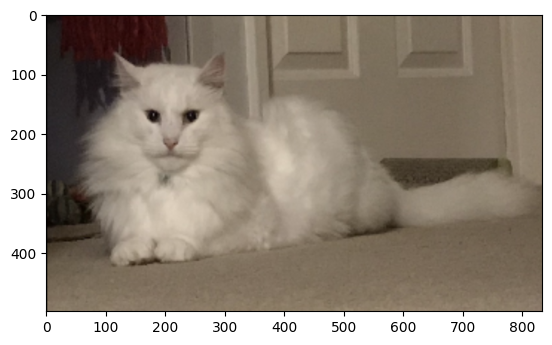

In [2]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
image = Image.open("cat.png")
imshow(image)

Doesn’t he look worried? Next, we’re going to set up some torchvision transforms to scale the image to the 224x224 required for ResNet and also to normalize it to the ImageNet mean/std.

In [7]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

In [4]:
# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

In [5]:
display_transform = transforms.Compose([
   transforms.Resize((224,224))])
tensor = preprocess(image)
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

Having converted our image into a PyTorch variable, we need a model to generate a prediction. Let’s use ResNet18, put it in evaluation mode, and stick it on the GPU using the CUDA libraries.

In [6]:
model = models.resnet101(pretrained=True)
model.cuda()
model.eval()

/home/dl-box/anaconda3/envs/yolov7_dsort/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/dl-box/anaconda3/envs/yolov7_dsort/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

This next bit of code is swiped from Jeremy Howard’s fast.ai course. It basically allows you to easily attach a hook to any model (or any part of a model - here we’re going to grab the final convnet layer in ResNet18) which will save the activation features as an instance variable.


In [8]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()
final_layer = model._modules.get('layer4')

activated_features = SaveFeatures(final_layer)

Having set that up, we run the image through our model and get the prediction. We then run that through a softmax layer to turn that prediction into a series of probabilities for each of the 1000 classes in ImageNet.


In [10]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

/home/dl-box/anaconda3/envs/yolov7_dsort/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Using topk(), we can see that our model is 78% confident that this picture is class 283. Looking that up in the ImageNet classes, that gives us…’persian cat’. I would say that’s not a bad guess!


In [11]:
topk(pred_probabilities,1)


torch.return_types.topk(
values=tensor([0.7525], device='cuda:0'),
indices=tensor([332], device='cuda:0'))

(
  0.7832
 [torch.cuda.FloatTensor of size 1 (GPU 0)], 
  283
 [torch.cuda.LongTensor of size 1 (GPU 0)])
Having made the guess, let’s see where the neural network was focussing its attention. The getCAM() method here takes the activated features of the convnet, the weights of the fully-connected layer (on the side of the average pooling), and the class index we want to investigate (283/‘persian cat’ in our case). We index into the fully-connected layer to get the weights for that class and calculate the dot product with our features from the image.

(this code is based on the paper that introduced CAM)

In [12]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [13]:

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
weight_softmax_params
class_idx = topk(pred_probabilities,1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

Now we can see our heatmap and overlay it onto Casper. It doesn’t make him look any happier, but we can see exactly where the model made its mind up about him.

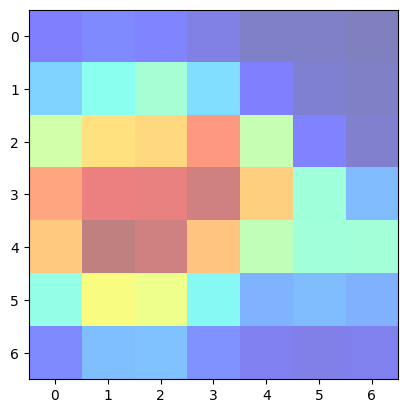

In [14]:
imshow(overlay[0], alpha=0.5, cmap='jet')


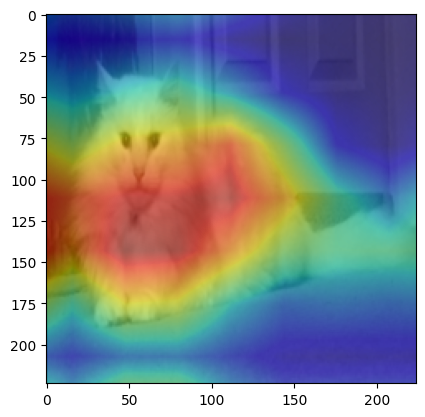

In [15]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet')

But wait, there’s a bit more - we can also look at the model’s second choice for Casper.


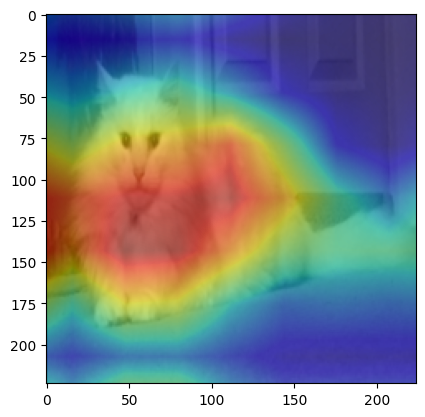

In [16]:
class_idx = topk(pred_probabilities,2)[1].int()

overlay = getCAM(activated_features.features, weight_softmax, 332 )

imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet')


Although the heatmap is similar, the network is focussing a touch more on his fluffy coat to suggest he might be class 332 - an Angora rabbit. And well, he is a Turkish Angora cat after all…